# Import Library

In [1]:
import urllib.request
import zipfile
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageDraw
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

In [2]:
physical_device = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_device[0], True)

# Download and Visualize Data

In [3]:
data_url_1 = 'https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip'
urllib.request.urlretrieve(data_url_1, 'emojis.zip')
local_file = 'emojis.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('emojis')

In [4]:
# Dict label emoji
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

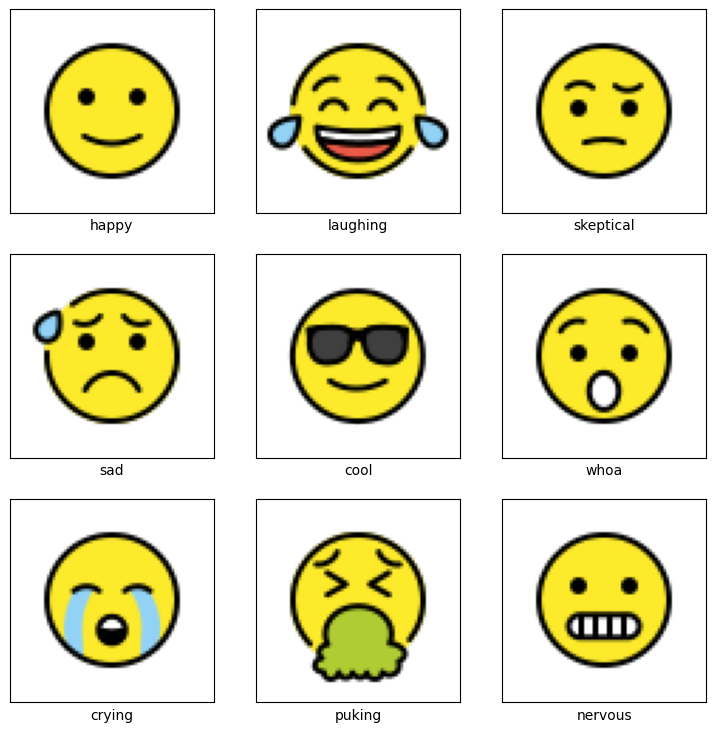

In [5]:
plt.figure(figsize=(9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

# Data Generator

## Placing an image at random location


In [6]:
for class_id, values in emojis.items():                                            #Take class_id and values in emojis.items
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')  #Open image in emojis, then convert them to RGBA
    png_file.load()                                                                #Load image
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))                    #Create a new image with all white
    new_file.paste(png_file, mask=png_file.split()[3])                             #Paste emoji image on new image
    emojis[class_id]['image'] = new_file                                           #Add "image" key to emojis for keep PIL value

In [7]:
emojis

{0: {'name': 'happy',
  'file': '1F642.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 1: {'name': 'laughing',
  'file': '1F602.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 2: {'name': 'skeptical',
  'file': '1F928.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 3: {'name': 'sad',
  'file': '1F630.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 4: {'name': 'cool',
  'file': '1F60E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 5: {'name': 'whoa',
  'file': '1F62F.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 6: {'name': 'crying',
  'file': '1F62D.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 7: {'name': 'puking',
  'file': '1F92E.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>},
 8: {'name': 'nervous',
  'file': '1F62C.png',
  'image': <PIL.Image.Image image mode=RGB size=72x72>}}

In [8]:
def create_example():
  class_id = np.random.randint(0, 9)                                          #Random choose an int from 0 to 9 for class_id
  image = np.ones((144, 144, 3)) * 255                                        #Create an 144x144x3 (white because of 255) array, call "image"
  row = np.random.randint(0, 72)                                              #Random choose an int from 0 to 72, call row
  col = np.random.randint(0, 72)                                              #Random choose an int from 0 to 72, call col
  image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])#Add PIL value to "image" from random row to row+72 and from random col to col+72
  return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144  #Return image as uint8, class_id, row, col
                                                                              #(original emoji image got 10 pixel margin on row and col, so we add 10 pix to get actual row and col, then we divide by 144 for normalize)

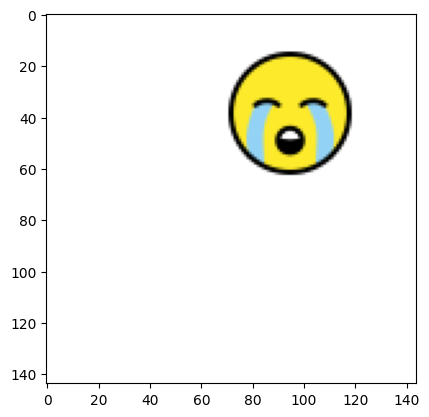

In [9]:
image, class_id, row, col = create_example()
plt.imshow(image)

## Add ground truth coordinates for boundary box

In [10]:
def plot_bounding_box(image, gt_coords, pred_coords=[], norm=False):       #image, ground truth coordinates, prediction coordinates, normalization flag
  if norm:                                                                 #if normalization flag is True,(it means our image values are normalized)
    image *= 255.                                                             #then image values will be de-normalized
    image = image.astype('uint8')                                             #and it will become an unsigned integer as a type. So we can use the image
  image = Image.fromarray(image)                                           #with "fromarray", we can display the image
  draw = ImageDraw.Draw(image)                                             #for drawing the bounding box on the image

  row, col = gt_coords
  row *= 144                                                               #multiply by 144 for de-normalized
  col *= 144
  draw.rectangle((col, row, col + 52, row + 52), outline='green', width=3) #Draw a green rectangle on image with from row to row+52 and from col to col+52(ground truth)

  if len(pred_coords) == 2:                                                #If length of prediction coordinates are 2(row and col)
    row, col = pred_coords
    row *= 144
    col *= 144
    draw.rectangle((col, row, col + 52, row + 52), outline='red', width=3) #Draw a red rectangle on image with from row to row+52 and from col to col+52(prediction)
  return image

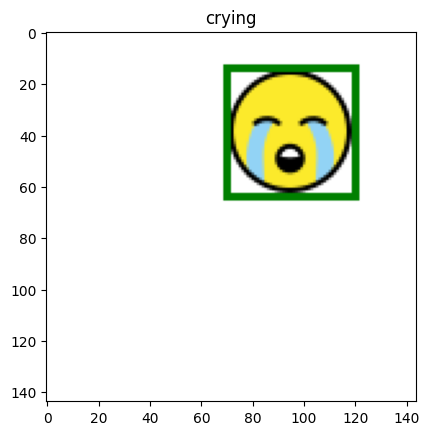

In [11]:
image = plot_bounding_box(image, gt_coords=[row, col])
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

## Prepare Dataset

In [12]:
def data_generator(batch_size=16):                                         #batch_size: number of training examples
  while True:
    x_batch = np.zeros((batch_size, 144, 144, 3))                          #Create a zeros array for images
    y_batch = np.zeros((batch_size, 9))                                    #Create a zeros array for classes
    bbox_batch = np.zeros((batch_size, 2))                                 #Create a zeros array for box(row, col)

    for i in range(0, batch_size):
      image, class_id, row, col = create_example()
      x_batch[i] = image / 255.                                            #image divide by 255 for normalizing
      y_batch[i, class_id] = 1.0                                           #Looks like => [0, 0, 0, 0, 1, 0, 0, 0, 0] (1 is for class_id if class_id is 5)
      bbox_batch[i] = np.array([row, col])
    yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}#"yield is a keyword that is used like return, except the function will return a generator"

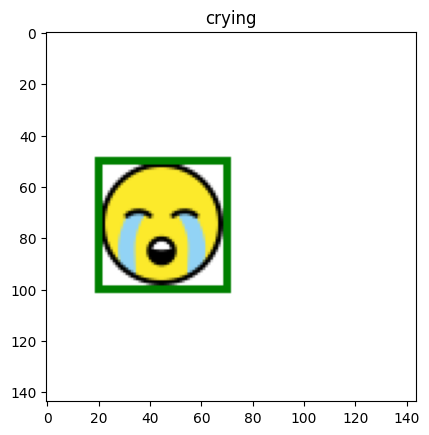

In [13]:
example, label = next(data_generator(1))           #Generate 1 example
image = example['image'][0]
class_id = np.argmax(label['class_out'][0])
coords = label['box_out'][0]

image = plot_bounding_box(image, coords, norm=True)
plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

# Modeling

In [14]:
input_ = Input(shape=(144, 144, 3), name='image')              #Input layer, shape is the image shape

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(9, activation='softmax', name='class_out')(x)#Dense layer with 9 units for class
box_out = Dense(2, name='box_out')(x)                          #Dense layer with 2 units for bounding box(row, col)

model = tf.keras.models.Model(input_, [class_out, box_out])    #Build model
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 144, 144, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 142, 142, 16)   │            448 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 142, 142, 16)   │             64 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 71, 71, 16)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 69, 69, 32)     │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 69, 69, 32)     │            128 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 34, 34, 32)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 32, 32, 64)     │         18,496 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 64)     │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 14, 14, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 14, 14, 128)    │            512 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 7, 7, 128)      │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 5, 5, 256)      │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 5, 5, 256)      │          1,024 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 659,819 (2.52 MB)

 Trainable params: 658,827 (2.51 MB)

 Non-trainable params: 992 (3.88 KB)

## Custom Metric: IoU

In [15]:
class IoU(tf.keras.metrics.Metric):                                        #Custom IoU class, inheritance of Metric class
  def __init__(self, **kwargs):
    super(IoU, self).__init__(**kwargs)                                    #super() allow us to use Metric class' arguments

    self.iou = self.add_weight(name='iou', initializer='zeros')            #add_weight: "Adds a new variable to the layer"
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

  def update_state(self, y_true, y_pred, sample_weight=None):
    def get_box(y):                                                        #a function for getting bounding box coordinates
      rows, cols = y[:, 0], y[:, 1]
      rows, cols = rows * 144, cols * 144
      y1, y2 = rows, rows + 52
      x1, x2 = cols, cols + 52
      return x1, y1, x2, y2

    def get_area(x1, y1, x2, y2):                                          #a function for getting area of bounding box
      return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

    gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)                           #getting ground truth bounding box coordinates
    p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)                               #getting prediction bounding box coordinates

    p_x1 = tf.cast(p_x1, tf.float32)
    p_y1 = tf.cast(p_y1, tf.float32)
    p_x2 = tf.cast(p_x2, tf.float32)
    p_y2 = tf.cast(p_y2, tf.float32)

    gt_x1 = tf.cast(gt_x1, tf.float32)
    gt_y1 = tf.cast(gt_y1, tf.float32)
    gt_x2 = tf.cast(gt_x2, tf.float32)
    gt_y2 = tf.cast(gt_y2, tf.float32)

    i_x1 = tf.maximum(gt_x1, p_x1)                                         #return the maximum of gt_x1 and p_x1, assign to i_x1
    i_y1 = tf.maximum(gt_y1, p_y1)                                         #return the maximum of gt_x1 and p_x1, assign to i_x1
    i_x2 = tf.minimum(gt_x2, p_x2)                                         #return the maximum of gt_x1 and p_x1, assign to i_x1
    i_y2 = tf.minimum(gt_y2, p_y2)                                         #return the maximum of gt_x1 and p_x1, assign to i_x1

    i_area = get_area(i_x1, i_y1, i_x2, i_y2)                              #area of intersection(or overlap)
    u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area #area of union

    iou = tf.math.divide(i_area, u_area)                                   #calculate the iou
    self.num_ex.assign_add(1)
    self.total_iou.assign_add(tf.reduce_mean(iou))                         #tf.reduce_mean():"Computes the mean of elements across dimensions of a tensor"
    self.iou = tf.math.divide(self.total_iou, self.num_ex)                 #total_iou divide by num_ex, then assign to iou

  def result(self):
    return self.iou

  def reset_state(self):                                                   #reseting the state
    self.iou = self.add_weight(name='iou', initializer='zeros')
    self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
    self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

## Compile the Model

In [16]:
model.compile(
    loss={
        'class_out': 'categorical_crossentropy',            #we have 2 outputs, one of which is class_out and we use "categorical_crossentropy" loss for it because class_out will be chosen from an array of 9 classes
        'box_out': 'mse'                                    #one of which is box_out, we use mse(mean squared error) loss for it because box_out return 2 numeric value(row and col)
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out': 'accuracy',                            #we use "accuracy" metric for class_out
        'box_out': IoU(name='iou')                          #and use our custom IoU class for box_out metric
    }
)

## Custom Callback: Model Testing

In [17]:
def test_model(model, test_datagen):    #a function for test the model
  example, label = next(test_datagen)
  x = example['image']
  y = label['class_out']
  box = label['box_out']

  pred_y, pred_box = model.predict(x)

  pred_coords = pred_box[0]
  gt_coords = box[0]
  pred_class = np.argmax(pred_y[0])     #np.argmax: "Returns the indices of the maximum values along an axis"
  image = x[0]

  gt = emojis[np.argmax(y[0])]['name']
  pred_class_name = emojis[pred_class]['name']

  image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
  color = 'green' if gt == pred_class_name else 'red'

  plt.imshow(image)
  plt.xlabel(f'Pred: {pred_class_name}', color=color)
  plt.ylabel(f'GT: {gt}', color=color)
  plt.xticks([])
  plt.yticks([])

In [18]:
def test(model):                   #a function for show the test result
  test_datagen = data_generator(1)

  plt.figure(figsize=(16, 4))

  for i in range(0, 6):
    plt.subplot(1, 6, i + 1)
    test_model(model, test_datagen)
  plt.show()
  plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


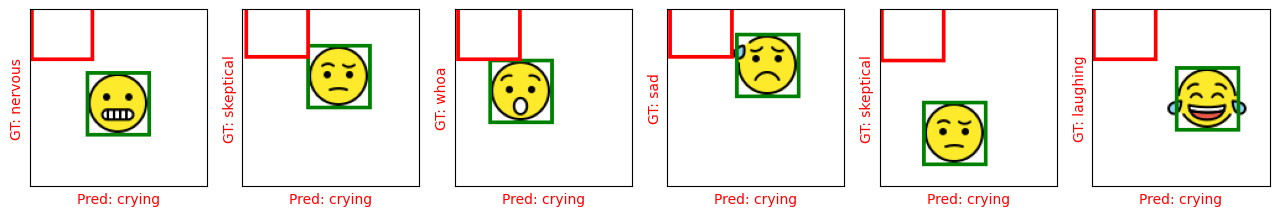

In [19]:
test(model)

In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get predictions within the callback's scope
        test_datagen = data_generator(1)

        # Create a new figure for each subplot
        fig = plt.figure(figsize=(16, 4))

        for i in range(0, 6):

            plt.subplot(1, 6, i + 1)
            test_model(self.model, test_datagen)

        plt.show()  # Show all the generated plots
        plt.close(fig)

## Model Training

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


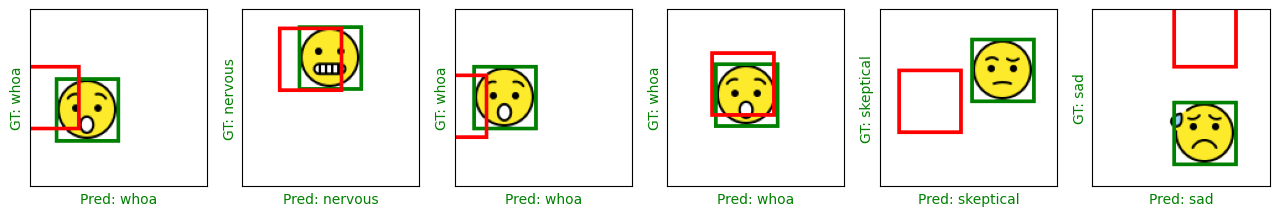

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - box_out_iou: 0.3742 - class_out_accuracy: 0.9985 - loss: 0.0616 - learning_rate: 0.0010
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


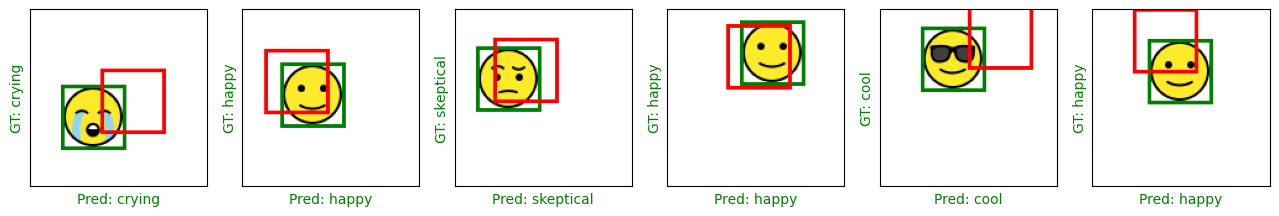

500/500 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - box_out_iou: 0.3639 - class_out_accuracy: 1.0000 - loss: 0.0208 - learning_rate: 0.0010
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


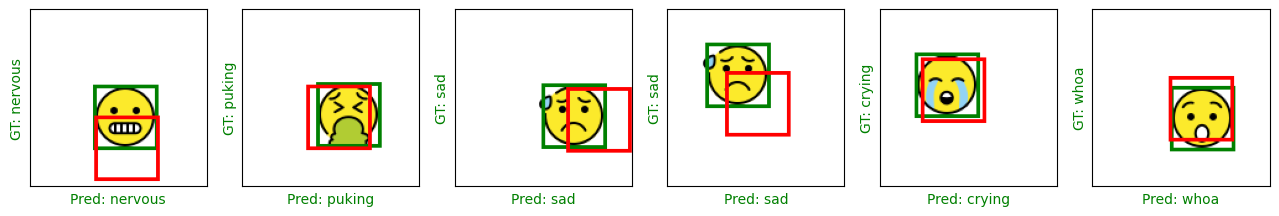

500/500 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - box_out_iou: 0.3893 - class_out_accuracy: 1.0000 - loss: 0.0119 - learning_rate: 0.0010
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


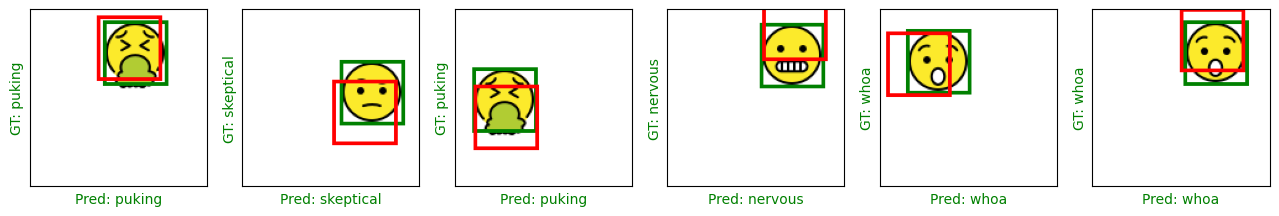

500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - box_out_iou: 0.4223 - class_out_accuracy: 1.0000 - loss: 0.0073 - learning_rate: 0.0010


In [22]:
def lr_schedule(epoch, lr):
  if (epoch + 1) % 5 == 0:
    lr *= 0.2              #at the end of every 5 epochs, the learning rate will multiplied by 0.2 for gradient descent
  return max(lr, 3e-7)     #compare learning rate and 0.0000003, then return the largest number. Because we want the minimum of learning rate is 0.0000003


_ = model.fit(
    data_generator(),
    epochs=50,
    steps_per_epoch=500,
    callbacks=[
               ShowTestImages(),                                                                #Custom callback
               tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=3, mode='max'), #Monitoring the box_out_iou for 3 epochs and if the quantity monitored has stopped increasing, then model.fit will be stop
               tf.keras.callbacks.LearningRateScheduler(lr_schedule)                            #"At the beginning of every epoch, this callback gets the updated learning rate value from schedule(lr_schedule) function"
    ]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


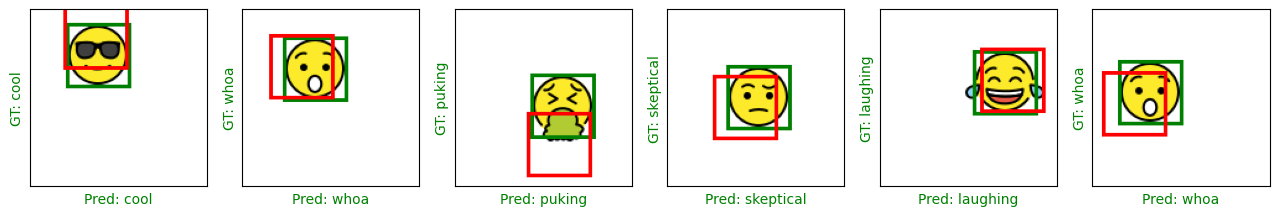

In [23]:
test(model)